<a href="https://colab.research.google.com/github/Tamzid19597/CryptoCurrencyPricePrediction/blob/main/LSTM-Model(sentiment-btc-AND-sentimewnt-btc-stock).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
!pip install pyspark
!pip install keras
!pip install sklearn
!pip install elephas


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from elephas.utils.rdd_utils import to_simple_rdd

### LSTM Time series on BTC-Tweeter Sentiment Data

Loading Dataset of tweetSentiment-btc

In [3]:
df1 = pd.read_csv('sentiment-btc.csv',header=None)
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2022-01-03,0.072606,0.800212,0.127091,0.107915,46458.117188
1,2022-01-04,0.046700,0.839960,0.113360,0.120762,45897.574219
2,2022-01-05,0.045441,0.839235,0.115353,0.210097,43569.003906
3,2022-01-06,0.070773,0.841568,0.087591,0.066923,43160.929688
4,2022-01-07,0.060919,0.843081,0.096000,0.092149,41557.902344


Loading Dataset of tweetSentiment(of btc)-nasdaq

In [4]:
df2 = pd.read_csv('sentiment-nasdaq.csv',header=None)
df2.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df2.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2022-01-03,0.072606,0.800212,0.127091,0.107915,15832.799805
1,2022-01-04,0.046700,0.839960,0.113360,0.120762,15622.719727
2,2022-01-05,0.045441,0.839235,0.115353,0.210097,15100.169922
3,2022-01-06,0.070773,0.841568,0.087591,0.066923,15080.860352
4,2022-01-07,0.060919,0.843081,0.096000,0.092149,14935.900391


plotting each column

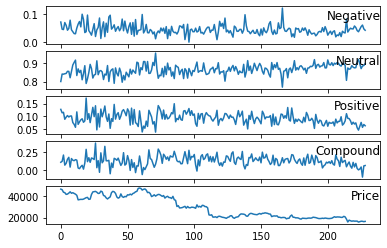

In [5]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df1.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Setting index

In [6]:
#btc
df1.set_index('DateTime',inplace=True)

In [7]:
#nasdaq
df2.set_index('DateTime',inplace=True)

In [8]:
#btc
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2022-01-03,46458.117188,0.072606,0.800212,0.127091,0.107915
2022-01-04,45897.574219,0.046700,0.839960,0.113360,0.120762
2022-01-05,43569.003906,0.045441,0.839235,0.115353,0.210097
2022-01-06,43160.929688,0.070773,0.841568,0.087591,0.066923
2022-01-07,41557.902344,0.060919,0.843081,0.096000,0.092149


In [9]:
#nasdaq
cols2 = df2.columns.tolist()
cols2 = cols2[-1:] + cols2[:-1]
df2 = df2[cols]
df2.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2022-01-03,15832.799805,0.072606,0.800212,0.127091,0.107915
2022-01-04,15622.719727,0.046700,0.839960,0.113360,0.120762
2022-01-05,15100.169922,0.045441,0.839235,0.115353,0.210097
2022-01-06,15080.860352,0.070773,0.841568,0.087591,0.066923
2022-01-07,14935.900391,0.060919,0.843081,0.096000,0.092149


Scalling Data

In [10]:
#btc
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2022-01-03,46458.117188,0.072606,0.800212,0.127091,0.107915
2022-01-04,45897.574219,0.046700,0.839960,0.113360,0.120762
2022-01-05,43569.003906,0.045441,0.839235,0.115353,0.210097
2022-01-06,43160.929688,0.070773,0.841568,0.087591,0.066923
2022-01-07,41557.902344,0.060919,0.843081,0.096000,0.092149


In [11]:
#nasdaq
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled2 = scaler2.fit_transform(df2.values)
df2.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2022-01-03,15832.799805,0.072606,0.800212,0.127091,0.107915
2022-01-04,15622.719727,0.046700,0.839960,0.113360,0.120762
2022-01-05,15100.169922,0.045441,0.839235,0.115353,0.210097
2022-01-06,15080.860352,0.070773,0.841568,0.087591,0.066923
2022-01-07,14935.900391,0.060919,0.843081,0.096000,0.092149


Feature Engineering

In [12]:
n_hours = 3
n_features = 5
n_obs = n_hours*n_features

Converts the original dataframe to a format which contains lag shifted values of inputs which can be used as input to the LSTM

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
#btc
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.968192,0.589760,0.164412,0.667581,0.436101,0.950498,0.379332,0.383946,0.566507,0.462687,0.876991,0.369107,0.379943,0.581177,0.647566,0.864109,0.574869,0.392828,0.376819,0.351267
4,0.950498,0.379332,0.383946,0.566507,0.462687,0.876991,0.369107,0.379943,0.581177,0.647566,0.864109,0.574869,0.392828,0.376819,0.351267,0.813506,0.494829,0.401184,0.438719,0.403472
5,0.876991,0.369107,0.379943,0.581177,0.647566,0.864109,0.574869,0.392828,0.376819,0.351267,0.813506,0.494829,0.401184,0.438719,0.403472,0.821820,0.350074,0.464199,0.485917,0.522919
6,0.864109,0.574869,0.392828,0.376819,0.351267,0.813506,0.494829,0.401184,0.438719,0.403472,0.821820,0.350074,0.464199,0.485917,0.522919,0.850691,0.400993,0.461859,0.443627,0.580824
7,0.813506,0.494829,0.401184,0.438719,0.403472,0.821820,0.350074,0.464199,0.485917,0.522919,0.850691,0.400993,0.461859,0.443627,0.580824,0.888990,0.644689,0.275157,0.472038,0.293230


In [15]:
#nasdaq
reframed2 = series_to_supervised(scaled2, n_hours, 1)
reframed2.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,1.000000,0.589760,0.164412,0.667581,0.436101,0.961883,0.379332,0.383946,0.566507,0.462687,0.867070,0.369107,0.379943,0.581177,0.647566,0.863567,0.574869,0.392828,0.376819,0.351267
4,0.961883,0.379332,0.383946,0.566507,0.462687,0.867070,0.369107,0.379943,0.581177,0.647566,0.863567,0.574869,0.392828,0.376819,0.351267,0.837265,0.494829,0.401184,0.438719,0.403472
5,0.867070,0.369107,0.379943,0.581177,0.647566,0.863567,0.574869,0.392828,0.376819,0.351267,0.837265,0.494829,0.401184,0.438719,0.403472,0.838522,0.350074,0.464199,0.485917,0.522919
6,0.863567,0.574869,0.392828,0.376819,0.351267,0.837265,0.494829,0.401184,0.438719,0.403472,0.838522,0.350074,0.464199,0.485917,0.522919,0.876738,0.400993,0.461859,0.443627,0.580824
7,0.837265,0.494829,0.401184,0.438719,0.403472,0.838522,0.350074,0.464199,0.485917,0.522919,0.876738,0.400993,0.461859,0.443627,0.580824,0.883077,0.644689,0.275157,0.472038,0.293230


In [16]:
#btc
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.968192,0.589760,0.164412,0.667581,0.436101,0.950498,0.379332,0.383946,0.566507,0.462687,0.876991,0.369107,0.379943,0.581177,0.647566,0.864109
4,0.950498,0.379332,0.383946,0.566507,0.462687,0.876991,0.369107,0.379943,0.581177,0.647566,0.864109,0.574869,0.392828,0.376819,0.351267,0.813506
5,0.876991,0.369107,0.379943,0.581177,0.647566,0.864109,0.574869,0.392828,0.376819,0.351267,0.813506,0.494829,0.401184,0.438719,0.403472,0.821820
6,0.864109,0.574869,0.392828,0.376819,0.351267,0.813506,0.494829,0.401184,0.438719,0.403472,0.821820,0.350074,0.464199,0.485917,0.522919,0.850691
7,0.813506,0.494829,0.401184,0.438719,0.403472,0.821820,0.350074,0.464199,0.485917,0.522919,0.850691,0.400993,0.461859,0.443627,0.580824,0.888990


In [17]:
#nasdaq
reframed2 = reframed2.drop(reframed2.columns[-4:], axis=1)
reframed2.head()


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,1.000000,0.589760,0.164412,0.667581,0.436101,0.961883,0.379332,0.383946,0.566507,0.462687,0.867070,0.369107,0.379943,0.581177,0.647566,0.863567
4,0.961883,0.379332,0.383946,0.566507,0.462687,0.867070,0.369107,0.379943,0.581177,0.647566,0.863567,0.574869,0.392828,0.376819,0.351267,0.837265
5,0.867070,0.369107,0.379943,0.581177,0.647566,0.863567,0.574869,0.392828,0.376819,0.351267,0.837265,0.494829,0.401184,0.438719,0.403472,0.838522
6,0.863567,0.574869,0.392828,0.376819,0.351267,0.837265,0.494829,0.401184,0.438719,0.403472,0.838522,0.350074,0.464199,0.485917,0.522919,0.876738
7,0.837265,0.494829,0.401184,0.438719,0.403472,0.838522,0.350074,0.464199,0.485917,0.522919,0.876738,0.400993,0.461859,0.443627,0.580824,0.883077


In [18]:
#btc
values = reframed.values
n_train_hours = 190
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(190, 16)

In [19]:
#nasdaq
values2 = reframed2.values
n_train_hours = 190
train2 = values2[:n_train_hours, :]
test2 = values2[n_train_hours:, :]
train2.shape

(190, 16)

Splitting into input and outputs

In [20]:
#btc
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [21]:
#nasdaq
train_X2, train_y2 = train2[:, :n_obs], train2[:, -n_features]
test_X2, test_y2 = test2[:, :n_obs], test2[:, -n_features]

Reshaping input to be 3D [samples, timesteps, features]

In [22]:
#btc
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(190, 3, 5) (190,) (36, 3, 5) (36,)


In [23]:
#nasdaq
train_X2 = train_X2.reshape((train_X2.shape[0], n_hours, n_features))
test_X2 = test_X2.reshape((test_X2.shape[0], n_hours, n_features))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)

(190, 3, 5) (190,) (36, 3, 5) (36,)


LSTM model design

In [24]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/100
48/48 - 3s - loss: 0.1231 - val_loss: 0.0684 - 3s/epoch - 69ms/step
Epoch 2/100
48/48 - 0s - loss: 0.0956 - val_loss: 0.0614 - 191ms/epoch - 4ms/step
Epoch 3/100
48/48 - 0s - loss: 0.0928 - val_loss: 0.0584 - 210ms/epoch - 4ms/step
Epoch 4/100
48/48 - 0s - loss: 0.0890 - val_loss: 0.0560 - 204ms/epoch - 4ms/step
Epoch 5/100
48/48 - 0s - loss: 0.0856 - val_loss: 0.0523 - 199ms/epoch - 4ms/step
Epoch 6/100
48/48 - 0s - loss: 0.0808 - val_loss: 0.0496 - 206ms/epoch - 4ms/step
Epoch 7/100
48/48 - 0s - loss: 0.0765 - val_loss: 0.0468 - 229ms/epoch - 5ms/step
Epoch 8/100
48/48 - 0s - loss: 0.0715 - val_loss: 0.0414 - 209ms/epoch - 4ms/step
Epoch 9/100
48/48 - 0s - loss: 0.0655 - val_loss: 0.0371 - 225ms/epoch - 5ms/step
Epoch 10/100
48/48 - 0s - loss: 0.0587 - val_loss: 0.0324 - 233ms/epoch - 5ms/step
Epoch 11/100
48/48 - 0s - loss: 0.0517 - val_loss: 0.0275 - 210ms/epoch - 4ms/step
Epoch 12/100
48/48 - 0s - loss: 0.0441 - val_loss: 0.0236 - 195ms/epoch - 4ms/step
Epoch 13/100
48

Train vs Test plot

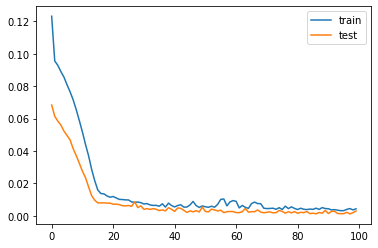

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Making Prediction and prediction score

In [26]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
test_X2 = test_X2.reshape((test_X2.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# invert scaling for stock(nasdaq)
test_y2 = test_y2.reshape((len(test_y2), 1))
inv_z = np.concatenate((test_y2, test_X2[:, -4:]), axis=1)
inv_z = scaler2.inverse_transform(inv_z)
inv_z = inv_z[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 1s 7ms/step
Test RMSE: 103.986


R2 score

In [27]:
r2_score(inv_y, inv_yhat)

0.9990044337173403

Plot prediction

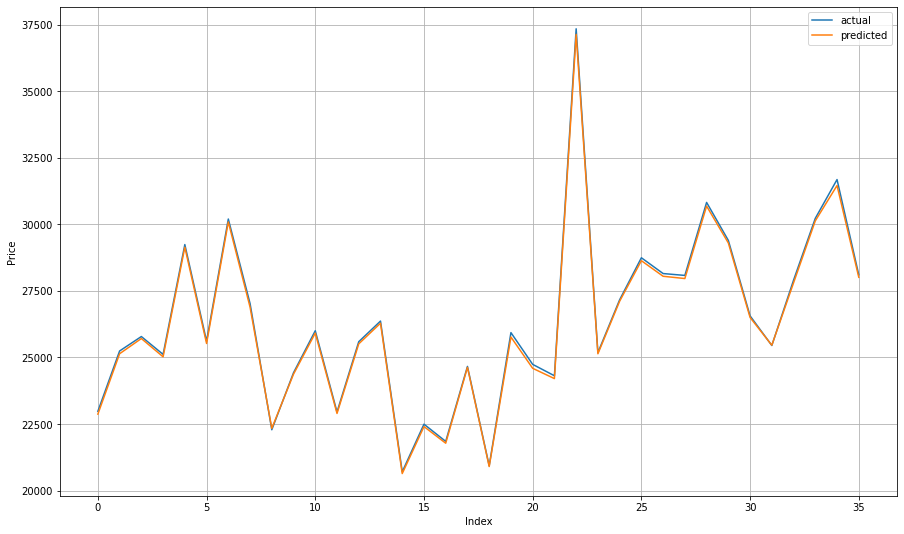

In [28]:
plt.figure(figsize=(15,9))
plt.grid(True)
plt.plot(inv_y,label='actual')
plt.plot(inv_yhat,label='predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

Compare with stock(nasdaq)

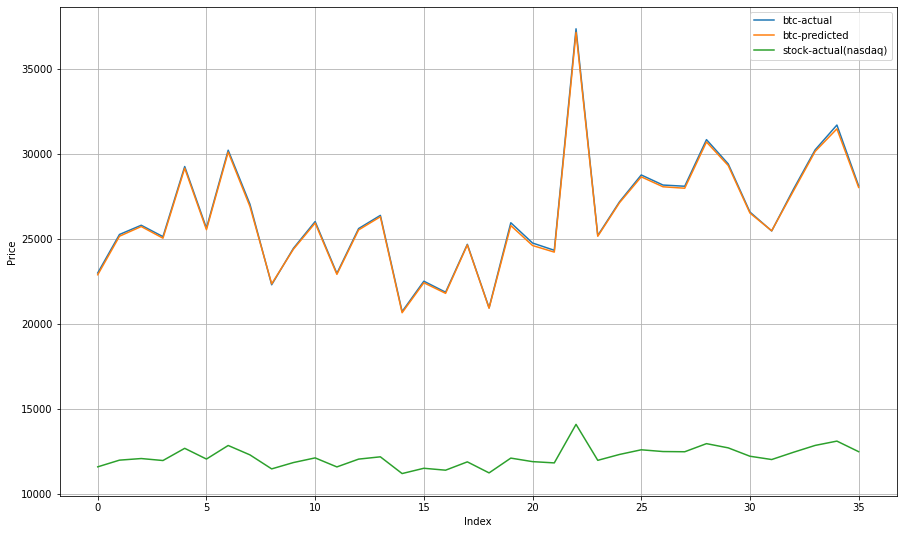

In [29]:
plt.figure(figsize=(15,9))
plt.grid(True)
plt.plot(inv_y,label='btc-actual')
plt.plot(inv_yhat,label='btc-predicted')
plt.plot(inv_z,label='stock-actual(nasdaq)')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

Frcasted Datset 

In [78]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent.csv')

### LSTM Time series on Stock-BTC-Tweeter Sentiment Data

Loading Dataset

In [57]:
df1 = pd.read_csv('sentiment-nasdaq-btc.csv',header=None)
df1.dropna()
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price','StockPrice']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price,StockPrice
0,2022-01-03,0.072606,0.800212,0.127091,0.107915,46458.117188,15832.799805
1,2022-01-04,0.046700,0.839960,0.113360,0.120762,45897.574219,15622.719727
2,2022-01-05,0.045441,0.839235,0.115353,0.210097,43569.003906,15100.169922
3,2022-01-06,0.070773,0.841568,0.087591,0.066923,43160.929688,15080.860352
4,2022-01-07,0.060919,0.843081,0.096000,0.092149,41557.902344,14935.900391


plotting each column

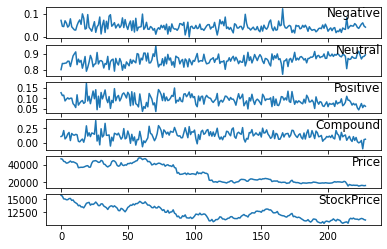

In [58]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5,6]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df1.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Setting index

In [59]:
df1.set_index('DateTime',inplace=True)

In [60]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,StockPrice,Negative,Neutral,Positive,Compound,Price
DateTime,,,,,,
2022-01-03,15832.799805,0.072606,0.800212,0.127091,0.107915,46458.117188
2022-01-04,15622.719727,0.046700,0.839960,0.113360,0.120762,45897.574219
2022-01-05,15100.169922,0.045441,0.839235,0.115353,0.210097,43569.003906
2022-01-06,15080.860352,0.070773,0.841568,0.087591,0.066923,43160.929688
2022-01-07,14935.900391,0.060919,0.843081,0.096000,0.092149,41557.902344


Scalling Data

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)
df1.head()

,StockPrice,Negative,Neutral,Positive,Compound,Price
DateTime,,,,,,
2022-01-03,15832.799805,0.072606,0.800212,0.127091,0.107915,46458.117188
2022-01-04,15622.719727,0.046700,0.839960,0.113360,0.120762,45897.574219
2022-01-05,15100.169922,0.045441,0.839235,0.115353,0.210097,43569.003906
2022-01-06,15080.860352,0.070773,0.841568,0.087591,0.066923,43160.929688
2022-01-07,14935.900391,0.060919,0.843081,0.096000,0.092149,41557.902344


Feature Engineering

In [62]:
n_hours = 3 #time lags
n_features = 6 #no of features
n_obs = n_hours*n_features

Converts the original dataframe to a format which contains lag shifted values of inputs which can be used as input to the LSTM

In [63]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [64]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
3,1.000000,0.589760,0.164412,0.667581,0.436101,0.968192,0.961883,0.379332,0.383946,0.566507,...,0.379943,0.581177,0.647566,0.876991,0.863567,0.574869,0.392828,0.376819,0.351267,0.864109
4,0.961883,0.379332,0.383946,0.566507,0.462687,0.950498,0.867070,0.369107,0.379943,0.581177,...,0.392828,0.376819,0.351267,0.864109,0.837265,0.494829,0.401184,0.438719,0.403472,0.813506
5,0.867070,0.369107,0.379943,0.581177,0.647566,0.876991,0.863567,0.574869,0.392828,0.376819,...,0.401184,0.438719,0.403472,0.813506,0.838522,0.350074,0.464199,0.485917,0.522919,0.821820
6,0.863567,0.574869,0.392828,0.376819,0.351267,0.864109,0.837265,0.494829,0.401184,0.438719,...,0.464199,0.485917,0.522919,0.821820,0.876738,0.400993,0.461859,0.443627,0.580824,0.850691
7,0.837265,0.494829,0.401184,0.438719,0.403472,0.813506,0.838522,0.350074,0.464199,0.485917,...,0.461859,0.443627,0.580824,0.850691,0.883077,0.644689,0.275157,0.472038,0.293230,0.888990


In [65]:
reframed = reframed.drop(reframed.columns[-5:], axis=1)
reframed.head()


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
3,1.000000,0.589760,0.164412,0.667581,0.436101,0.968192,0.961883,0.379332,0.383946,0.566507,0.462687,0.950498,0.867070,0.369107,0.379943,0.581177,0.647566,0.876991,0.863567
4,0.961883,0.379332,0.383946,0.566507,0.462687,0.950498,0.867070,0.369107,0.379943,0.581177,0.647566,0.876991,0.863567,0.574869,0.392828,0.376819,0.351267,0.864109,0.837265
5,0.867070,0.369107,0.379943,0.581177,0.647566,0.876991,0.863567,0.574869,0.392828,0.376819,0.351267,0.864109,0.837265,0.494829,0.401184,0.438719,0.403472,0.813506,0.838522
6,0.863567,0.574869,0.392828,0.376819,0.351267,0.864109,0.837265,0.494829,0.401184,0.438719,0.403472,0.813506,0.838522,0.350074,0.464199,0.485917,0.522919,0.821820,0.876738
7,0.837265,0.494829,0.401184,0.438719,0.403472,0.813506,0.838522,0.350074,0.464199,0.485917,0.522919,0.821820,0.876738,0.400993,0.461859,0.443627,0.580824,0.850691,0.883077


In [66]:
values = reframed.values
n_train_hours = 190
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(190, 19)

Splitting into input and outputs

In [67]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

Reshaping input to be 3D [samples, timesteps, features]

In [68]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(190, 3, 6) (190,) (36, 3, 6) (36,)


LSTM model design

In [69]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/100
48/48 - 5s - loss: 0.3116 - val_loss: 0.1489 - 5s/epoch - 95ms/step
Epoch 2/100
48/48 - 0s - loss: 0.1290 - val_loss: 0.0746 - 178ms/epoch - 4ms/step
Epoch 3/100
48/48 - 0s - loss: 0.1073 - val_loss: 0.0754 - 176ms/epoch - 4ms/step
Epoch 4/100
48/48 - 0s - loss: 0.1057 - val_loss: 0.0749 - 190ms/epoch - 4ms/step
Epoch 5/100
48/48 - 0s - loss: 0.1034 - val_loss: 0.0726 - 167ms/epoch - 3ms/step
Epoch 6/100
48/48 - 0s - loss: 0.1003 - val_loss: 0.0698 - 169ms/epoch - 4ms/step
Epoch 7/100
48/48 - 0s - loss: 0.0964 - val_loss: 0.0663 - 192ms/epoch - 4ms/step
Epoch 8/100
48/48 - 0s - loss: 0.0920 - val_loss: 0.0623 - 176ms/epoch - 4ms/step
Epoch 9/100
48/48 - 0s - loss: 0.0863 - val_loss: 0.0592 - 161ms/epoch - 3ms/step
Epoch 10/100
48/48 - 0s - loss: 0.0791 - val_loss: 0.0559 - 177ms/epoch - 4ms/step
Epoch 11/100
48/48 - 0s - loss: 0.0708 - val_loss: 0.0518 - 184ms/epoch - 4ms/step
Epoch 12/100
48/48 - 0s - loss: 0.0609 - val_loss: 0.0495 - 165ms/epoch - 3ms/step
Epoch 13/100
48

Train vs Test plot

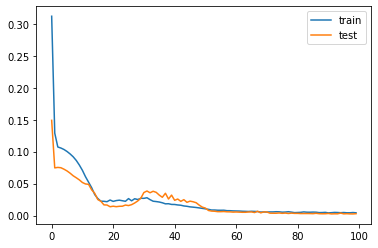

In [70]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Making Prediction and prediction score

In [71]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 1s 7ms/step
Test RMSE: 28.089


R2 score

In [72]:
r2_score(inv_y, inv_yhat)

0.9976000660688505

Plot prediction

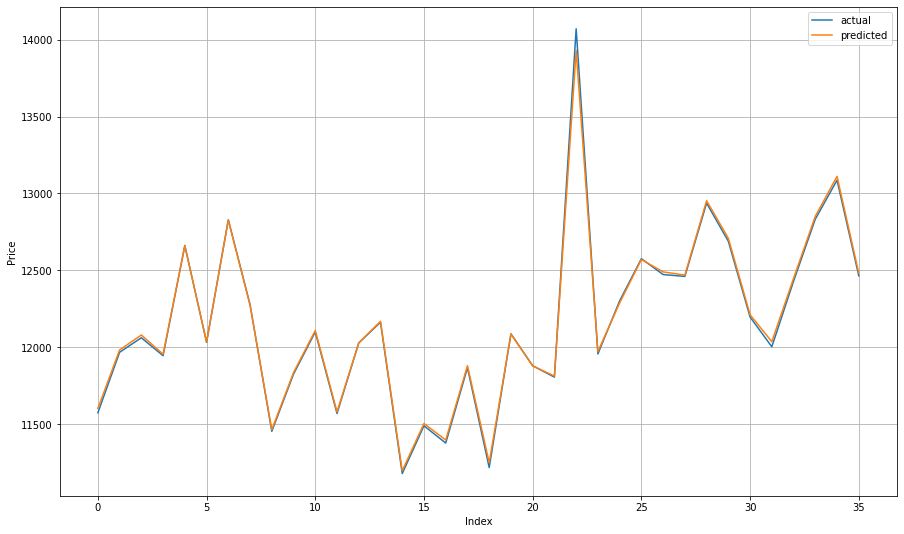

In [74]:
plt.figure(figsize=(15,9))
plt.grid(True)
plt.plot(inv_y,label='actual')
plt.plot(inv_yhat,label='predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

Frcasted Datset 

In [56]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent.csv')